# Preprocessing

In [ ]:
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 115 (delta 6), reused 14 (delta 2), pack-reused 97
Receiving objects: 100% (115/115), 46.62 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
%cd NASA-Material-Classifier

/content/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier


In [ ]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import torch.nn.functional as F
import tensorflow as tf
tf.random.set_seed(1000)
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import scipy.io
import torch.nn as nn
from sklearn.model_selection import train_test_split
import uuid
import torch
from keras.layers import Bidirectional, LSTM, Dense
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
file_paths = dict()
file_paths[0] = [
    "data/S11_parameter_data_for_zero_orientation.txt",
    "data/S12_parameter_data_for_zero_orientation.txt",
    "data/S21_parameter_data_for_zero_orientation.txt",
    "data/S22_parameter_data_for_zero_orientation.txt"]
file_paths[1] = [
    "data/S11_parameter_data_for_CW90_orientation.txt",
    "data/S12_parameter_data_for_CW90_orientation.txt",
    "data/S21_parameter_data_for_CW90_orientation.txt",
    "data/S22_parameter_data_for_CW90_orientation.txt"]
file_paths[2] = [
    "data/S11_parameter_data_for_CCW90_orientation.txt",
    "data/S12_parameter_data_for_CCW90_orientation.txt",
    "data/S21_parameter_data_for_CCW90_orientation.txt",
    "data/S22_parameter_data_for_CCW90_orientation.txt"]
file_paths[3] = [
    "data/S11_parameter_data_for_tilt_orientation.txt",
    "data/S12_parameter_data_for_tilt_orientation.txt",
    "data/S21_parameter_data_for_tilt_orientation.txt",
    "data/S22_parameter_data_for_tilt_orientation.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [ ]:
file_paths = dict()
file_paths[0] = ["data/mea_rot_0.txt"]
file_paths[1] = ["data/mea_rot_cw90.txt"]
file_paths[2] = ["data/mea_rot_ccw90.txt"]
file_paths[3] = ["data/mea_rot_0_tilt.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    dictionary = {
    0: "S11",
    1: "S21",
    2: "S12",
    3: "S22"
    }
    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = dictionary[index]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for group in range(len(all_combined_data)):
    for i in range(0, len(all_combined_data[group]), group_size):
        combined_dataframe = pd.concat(all_combined_data[group][i:i+group_size], axis=1)
        combined_dataframe.reset_index(drop=True, inplace=True)
        array.append(combined_dataframe)
testing_dataframe = pd.concat(array, axis=0)
testing_dataframe.reset_index(drop=True, inplace=True)
testing_dataframe = testing_dataframe.loc[:, ~testing_dataframe.columns.duplicated()]

In [ ]:
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [ ]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [ ]:
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [ ]:
training_dataframe = training_dataframe.iloc[:,1:]
testing_dataframe = testing_dataframe.iloc[:,1:]

In [ ]:
testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1

<ipython-input-665-45854e52fc1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1


In [ ]:
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,0.022609,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,1.0007,0,0.022609,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,1.0014,0,0.022609,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,1.0021,0,0.022609,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,1.0028,0,0.022609,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [ ]:
testing_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,0.05,0.1,-0.019713,-0.006039,0.999223,-0.020864,0.998418,-0.021599,0.021095,-0.006780
1,1.0007,0,0.05,0.1,-0.019483,-0.006385,0.998718,-0.020889,0.998630,-0.021391,0.020911,-0.007270
2,1.0014,0,0.05,0.1,-0.019138,-0.006591,0.998271,-0.020941,0.998445,-0.021038,0.020691,-0.007730
3,1.0021,0,0.05,0.1,-0.018813,-0.006997,0.998203,-0.020768,0.998248,-0.020766,0.020422,-0.008105
4,1.0028,0,0.05,0.1,-0.018616,-0.007612,0.998520,-0.020519,0.998265,-0.020615,0.020164,-0.008383


In [ ]:
training_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000
mean,1.350000,1.500000,0.051183,0.048120,-0.001584,-0.002185,-0.047022,-0.054192,-0.047022,-0.054192,0.000979,-0.001394
std,0.202275,1.118035,0.022764,0.028907,0.015331,0.016359,0.717936,0.684740,0.717936,0.684740,0.016112,0.015731
min,1.000000,0.000000,0.010952,0.000463,-0.035654,-0.041414,-0.995684,-0.994878,-0.995684,-0.994878,-0.039840,-0.041402
25%,1.175000,0.750000,0.030552,0.023333,-0.012621,-0.013896,-0.764701,-0.733799,-0.764701,-0.733799,-0.010682,-0.012373
50%,1.350000,1.500000,0.053121,0.045073,-0.002871,-0.001957,-0.111570,-0.084830,-0.111570,-0.084830,0.001433,-0.000090
75%,1.525000,2.250000,0.070425,0.077511,0.008562,0.009605,0.685784,0.613695,0.685784,0.613695,0.012647,0.010078
max,1.700000,3.000000,0.087647,0.099613,0.041451,0.040683,0.995090,0.995193,0.995090,0.995193,0.040707,0.035653


In [ ]:
testing_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,4004.0000,4004.000000,4.004000e+03,4.004000e+03,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,1.3500,1.500000,5.000000e-02,1.000000e-01,0.000577,0.000549,0.999238,-0.015901,0.999127,-0.016045,0.000196,0.000537
std,0.2023,1.118174,6.939761e-18,1.387952e-17,0.011171,0.011518,0.000563,0.002759,0.000539,0.002727,0.011191,0.011311
min,1.0000,0.000000,5.000000e-02,1.000000e-01,-0.020254,-0.019533,0.997404,-0.022488,0.997087,-0.022932,-0.016647,-0.019633
25%,1.1750,0.750000,5.000000e-02,1.000000e-01,-0.009929,-0.010517,0.998914,-0.017570,0.998798,-0.017717,-0.010537,-0.010187
50%,1.3500,1.500000,5.000000e-02,1.000000e-01,0.000705,0.001933,0.999316,-0.016833,0.999181,-0.016949,-0.000033,0.001886
75%,1.5250,2.250000,5.000000e-02,1.000000e-01,0.010853,0.011191,0.999648,-0.015271,0.999511,-0.015336,0.010635,0.010881
max,1.7000,3.000000,5.000000e-02,1.000000e-01,0.019258,0.017582,1.000619,-0.010323,1.000495,-0.010558,0.021095,0.017354


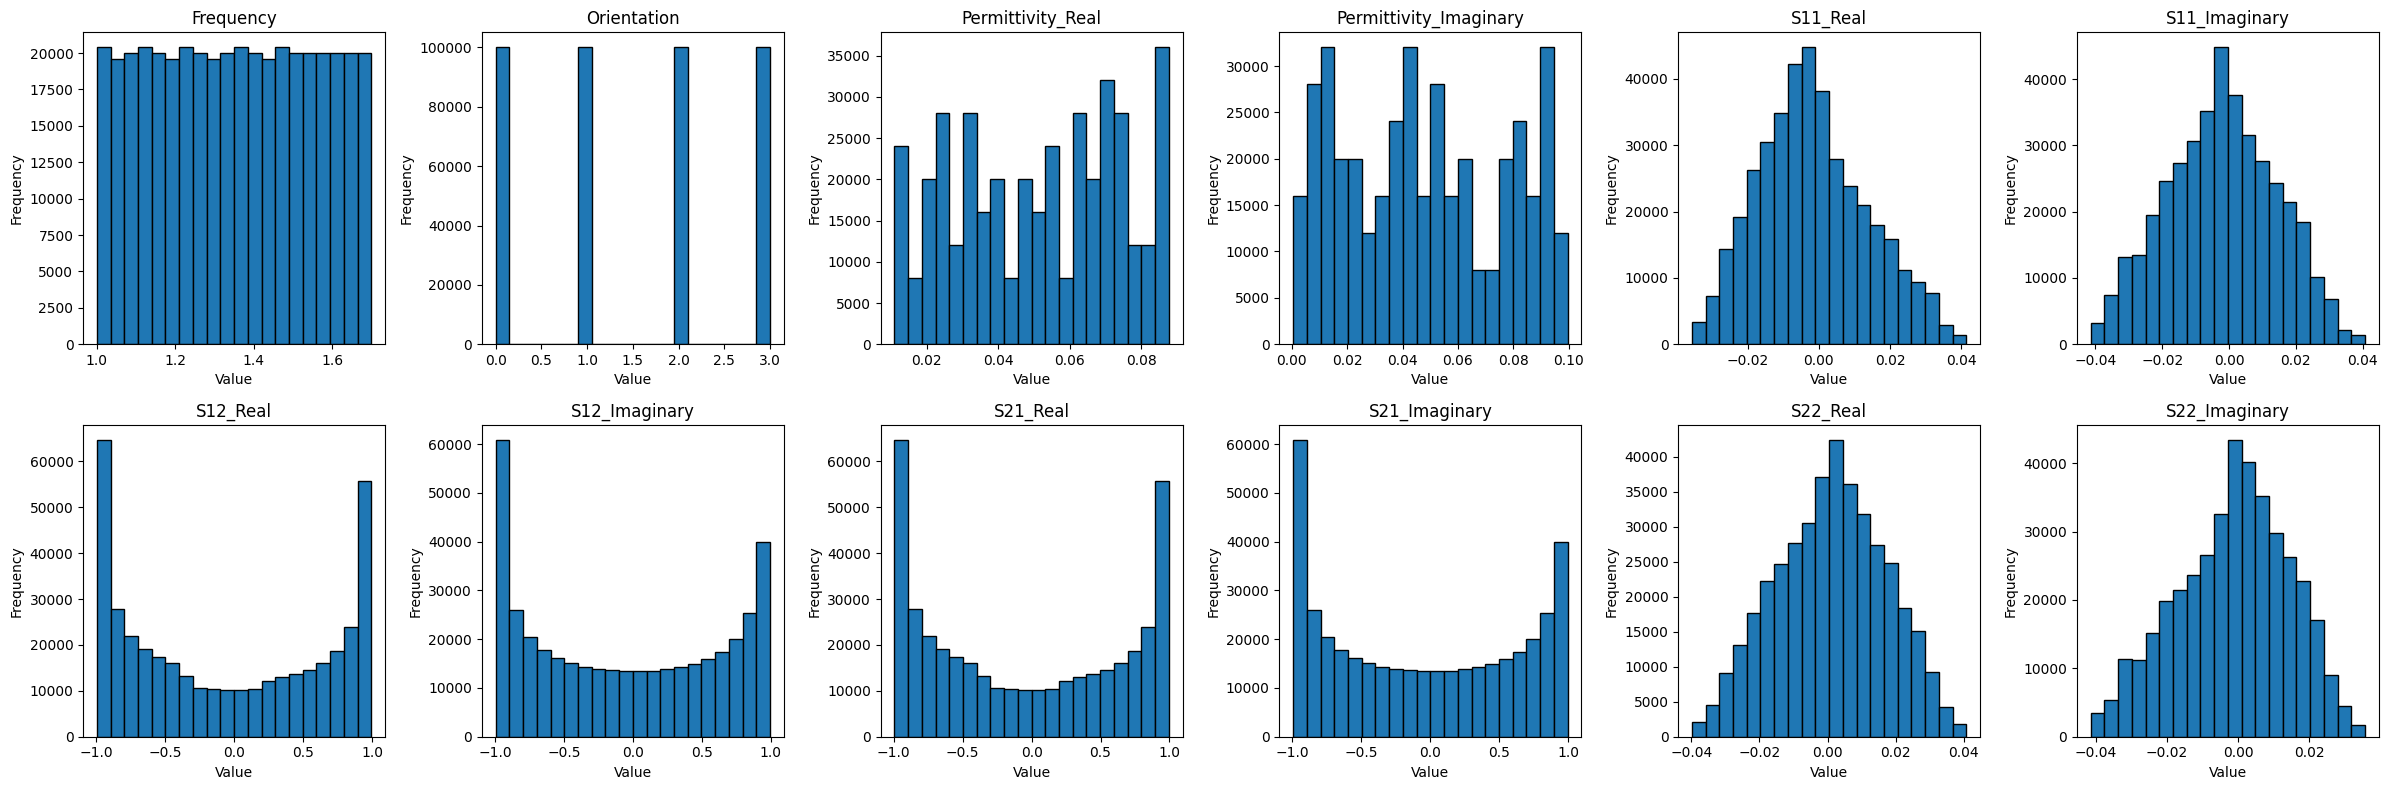

In [ ]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

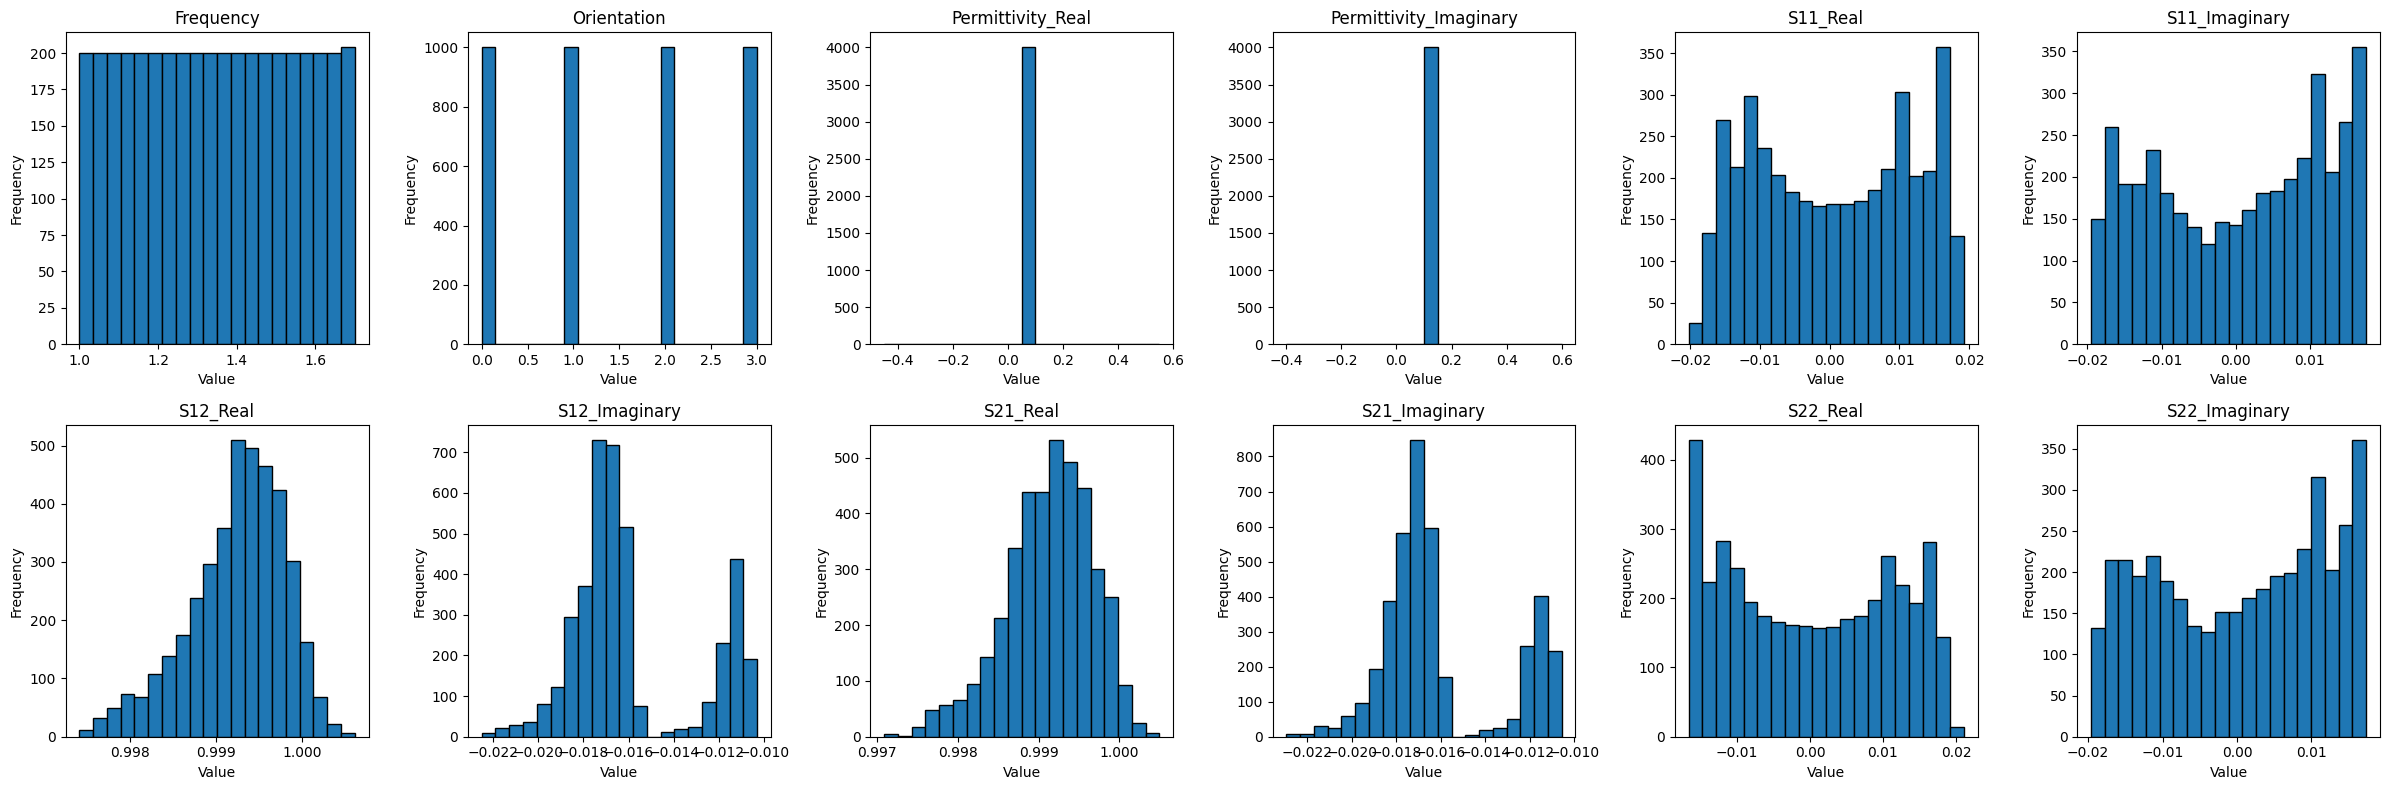

In [ ]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

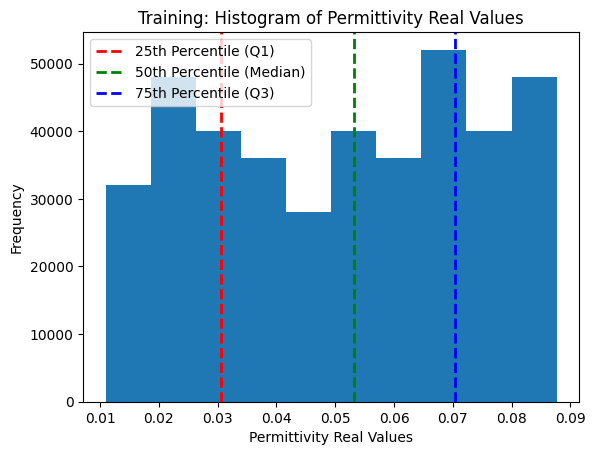

In [ ]:
q25 = np.percentile(training_dataframe["Permittivity_Real"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Real"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Real"], 75)
plt.hist(training_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Real Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

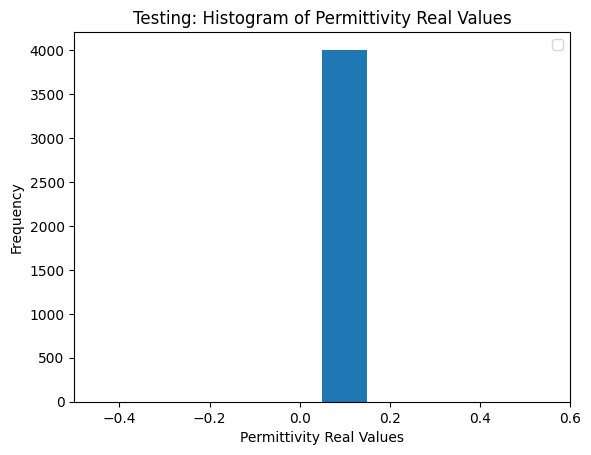

In [ ]:
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

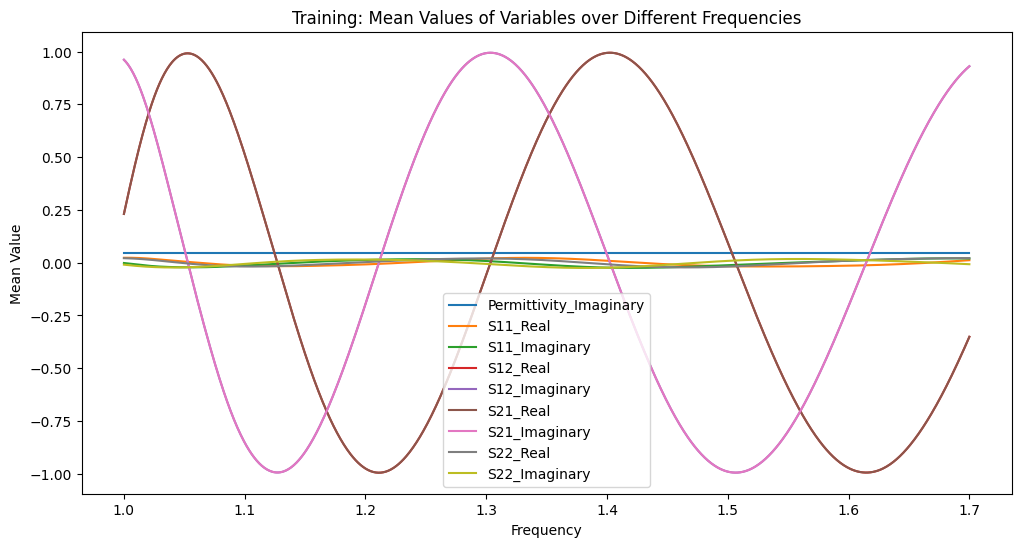

In [ ]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

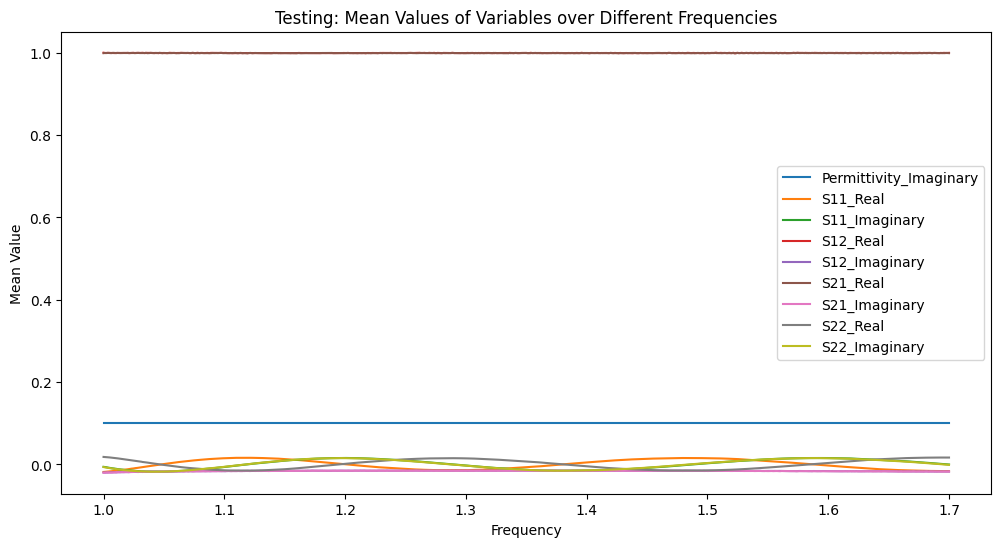

In [ ]:
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Testing: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

In [ ]:
no_id = [
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary','Permittivity_Real','Permittivity_Imaginary']

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
bc = QuantileTransformer()
bc.fit(training_dataframe[no_id])
training_dataframe[training_dataframe[no_id].columns] = bc.transform(training_dataframe[no_id])
testing_dataframe[testing_dataframe[no_id].columns]  = bc.transform(testing_dataframe[no_id])

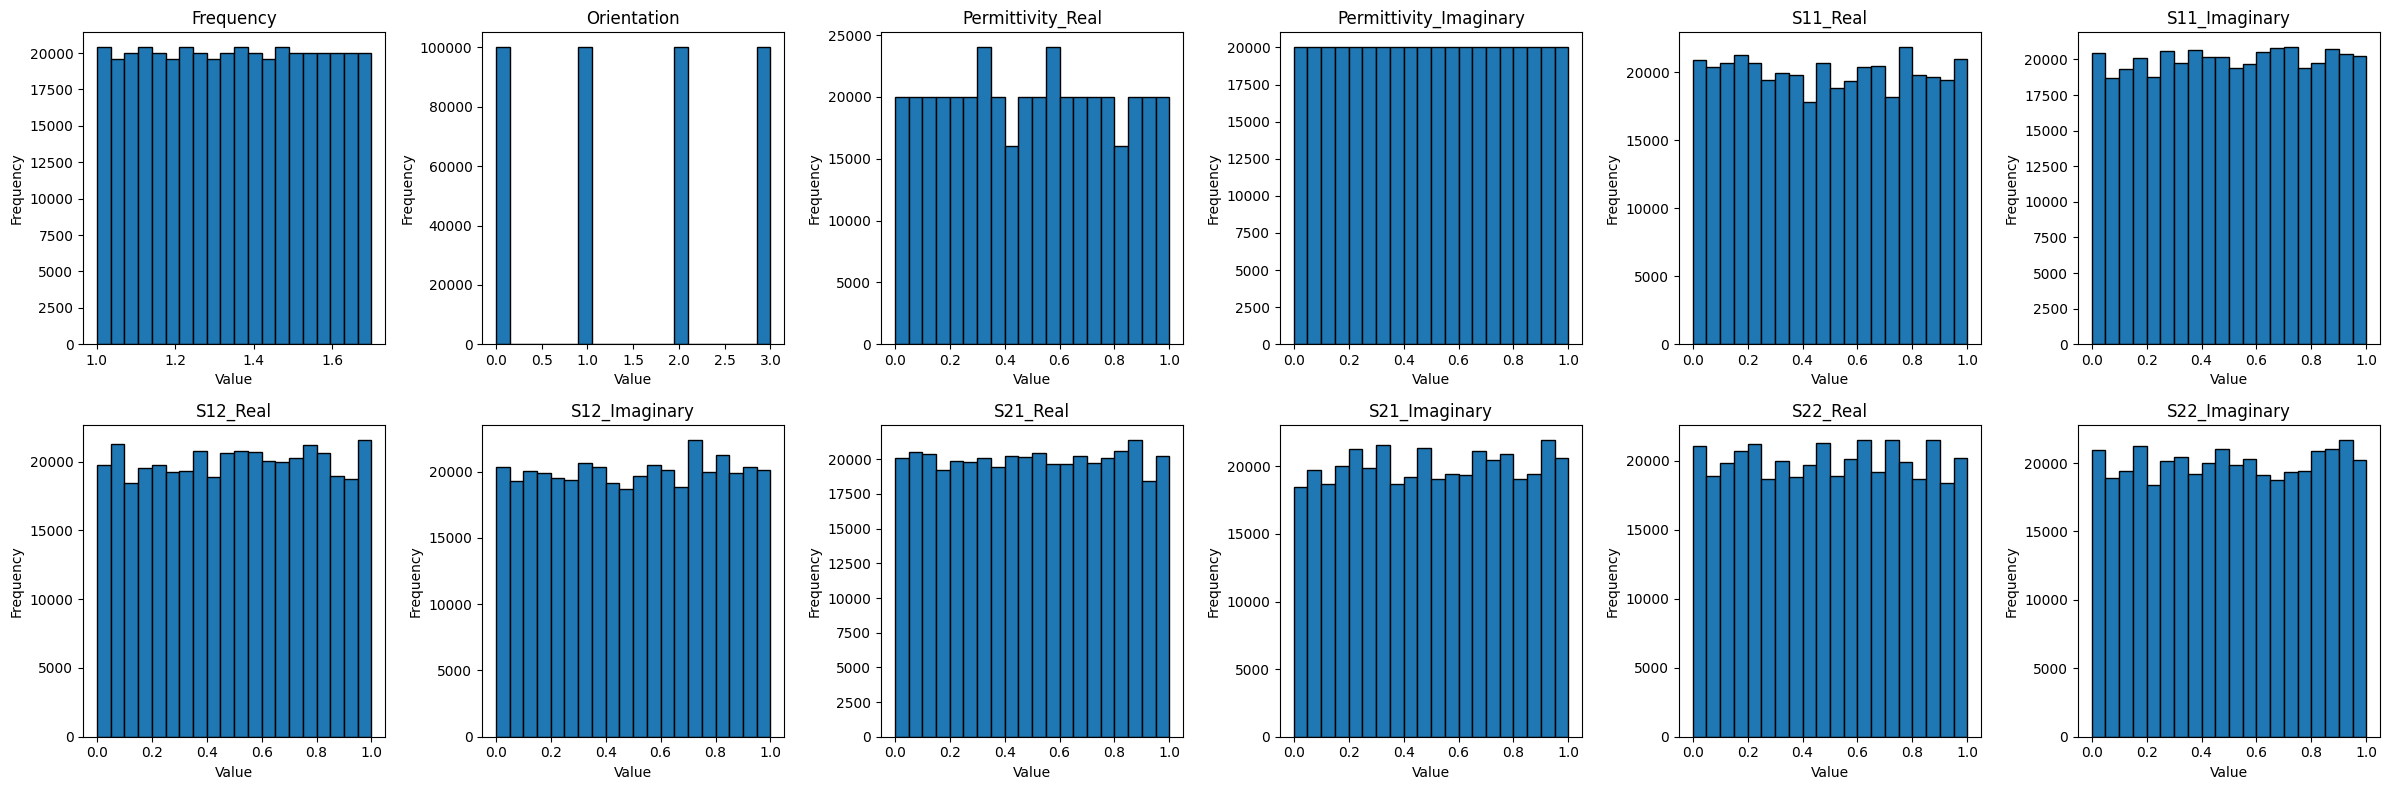

In [ ]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

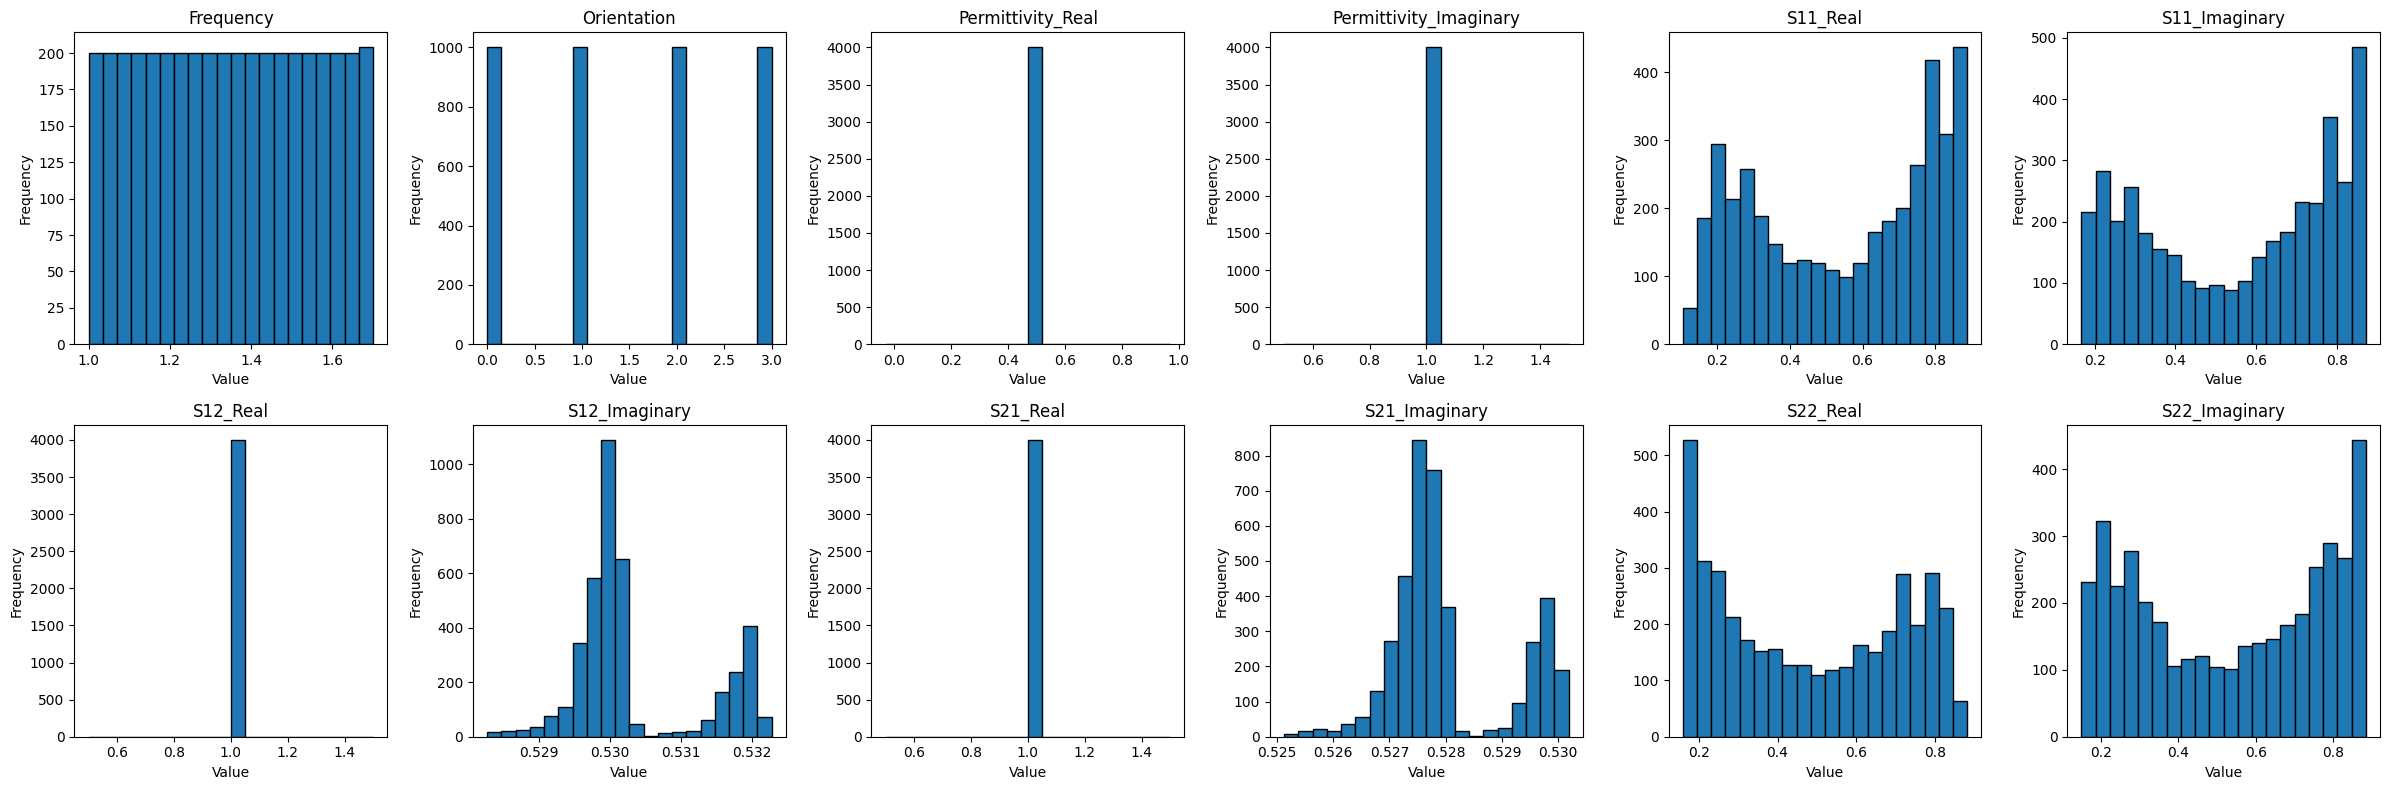

In [ ]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Feedforward neural network

In [ ]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID"]:
        columns.append(column)
columns

['Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [ ]:
X_train = training_dataframe[columns].values
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
grouped_indices = {}
for idx in selected_indices:
    row = training_dataframe.iloc[idx]
    orientation = row['Orientation']
    frequency = row['Frequency']
    key = (orientation, frequency)
    if key not in grouped_indices:
        grouped_indices[key] = []
    grouped_indices[key].append(idx)
X_train_indices = []
X_val_indices = []
for key, indices in grouped_indices.items():
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    X_train_indices.extend(train_indices)
    X_val_indices.extend(val_indices)
X_train = X_selected[X_train_indices]
y_train = y_selected[X_train_indices]
X_val = X_selected[X_val_indices]
y_val = y_selected[X_val_indices]
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

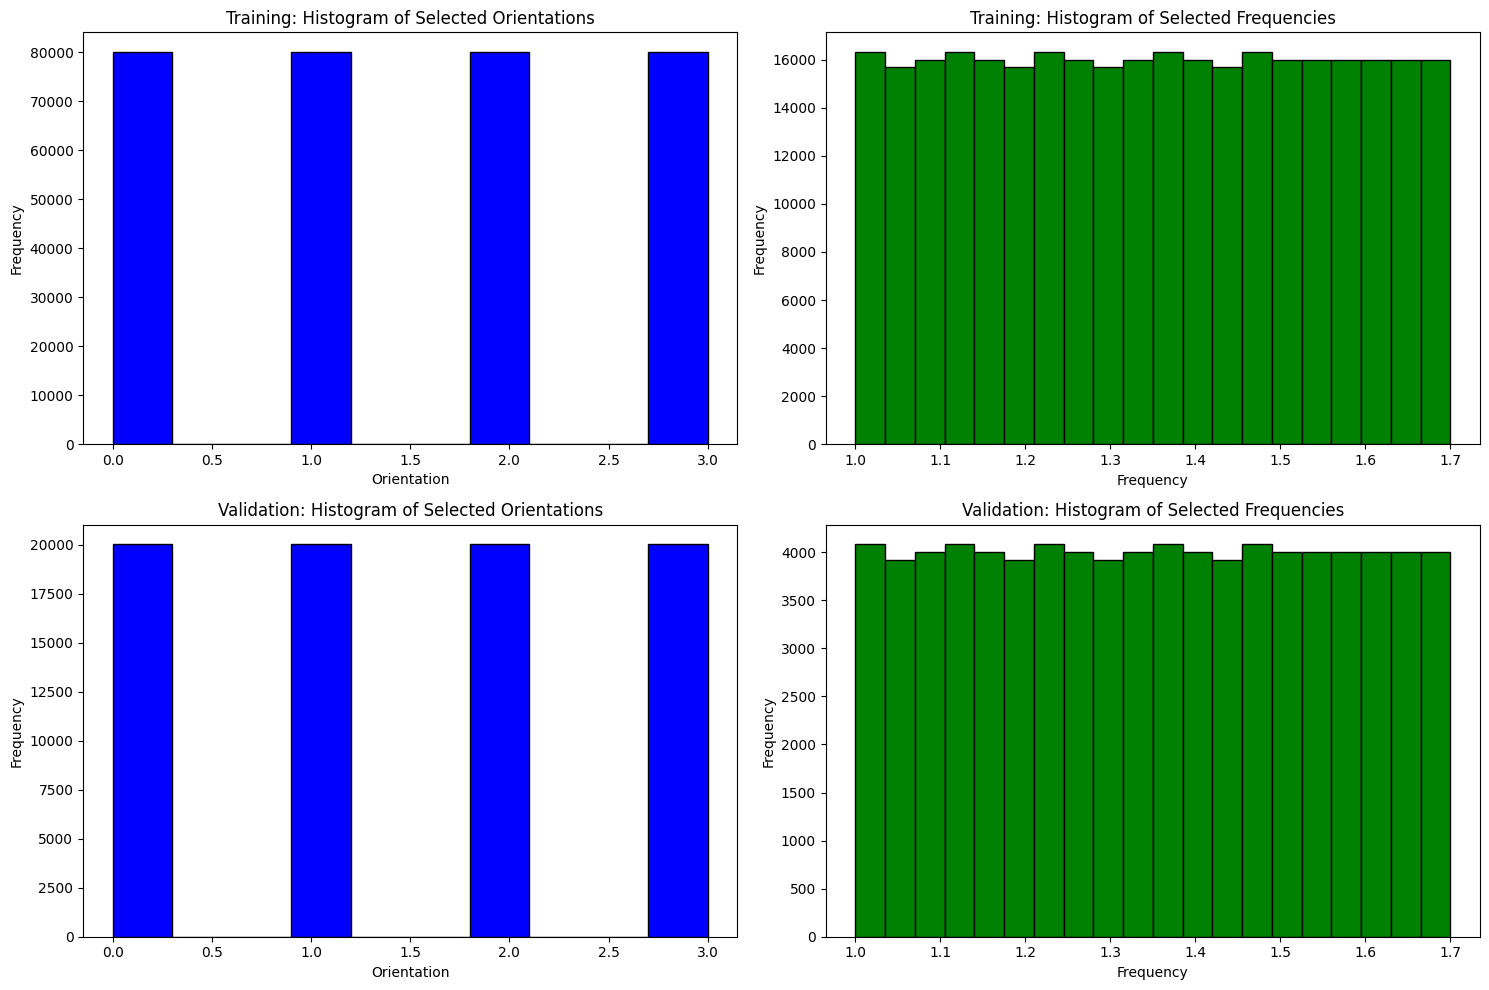

In [ ]:
selected_orientations = training_dataframe.loc[X_train_indices, 'Orientation']
selected_frequencies = training_dataframe.loc[X_train_indices, 'Frequency']

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Training: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Training: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

selected_orientations = training_dataframe.loc[X_val_indices, 'Orientation']
selected_frequencies = training_dataframe.loc[X_val_indices, 'Frequency']

plt.subplot(2, 2, 3)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Validation: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Validation: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_170 (Dense)           (None, 128)               1408      
                                                                 
 dense_171 (Dense)           (None, 64)                8256      
                                                                 
 dense_172 (Dense)           (None, 32)                2080      
                                                                 
 dense_173 (Dense)           (None, 16)                528       
                                                                 
 dense_174 (Dense)           (None, 2)                 34        
                                                                 
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
33/33 [==============================

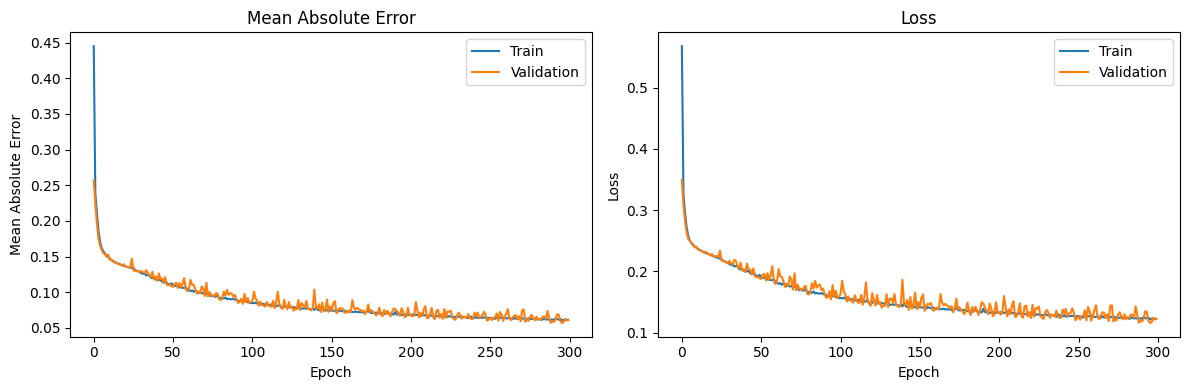

In [ ]:
def rmse_loss(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    mean_squared_error = tf.reduce_mean(squared_error)
    root_mean_squared_error = tf.sqrt(mean_squared_error)
    return root_mean_squared_error

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001,weight_decay=0.000001),
              loss=[rmse_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=10000,shuffle=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
def remove_outliers(y_pred, y_test, threshold=2):
    z_scores = np.abs((y_pred - np.mean(y_pred)) / np.std(y_pred))
    outliers_mask = z_scores > 2.0

    y_pred_filtered = y_pred[~outliers_mask]
    y_test_filtered = y_test[~outliers_mask]

    return y_pred_filtered, y_test_filtered

# Assuming you have y_pred, y_test, and X_test available
y_pred_0, y_test_filtered_0 = remove_outliers(y_pred[:, 0], y_test[:, 0], threshold=2.0)
y_pred_1, y_test_filtered_1 = remove_outliers(y_pred[:, 1], y_test[:, 1], threshold=2.0)


126/126 [==============================] - 0s 1ms/step


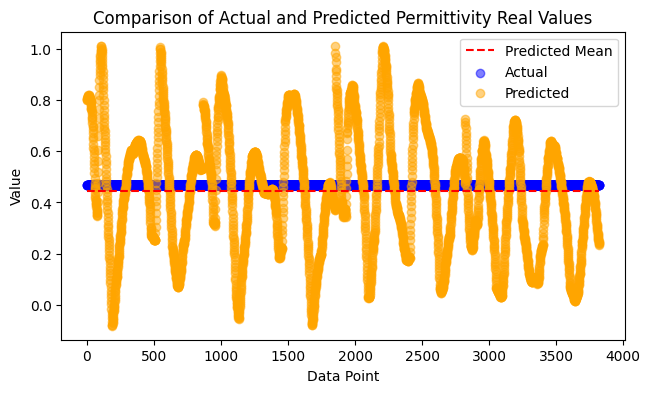

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_0) - 1], [np.mean(y_pred_0), np.mean(y_pred_0)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_0)),y_test_filtered_0, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_0)), y_pred_0, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

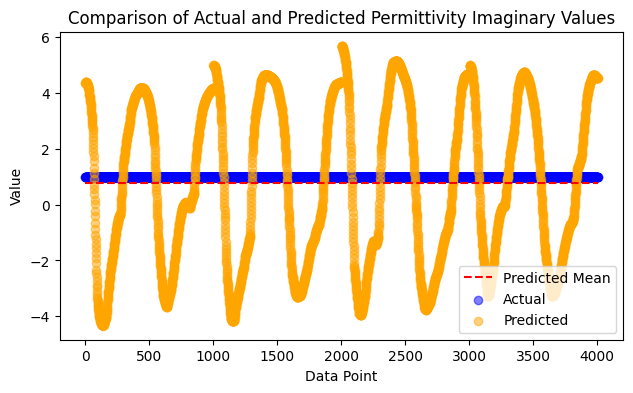

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_1) - 1], [np.mean(y_pred_1), np.mean(y_pred_1)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_1)), y_test_filtered_1, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_1)), y_pred_1, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

In [ ]:
X_train = training_dataframe[columns].values
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 128)               1408      
                                                                 
 dense_191 (Dense)           (None, 64)                8256      
                                                                 
 dense_192 (Dense)           (None, 32)                2080      
                                                                 
 dense_193 (Dense)           (None, 16)                528       
                                                                 
 dense_194 (Dense)           (None, 2)                 34        
                                                                 
Total params: 12,306
Trainable params: 12,306
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
81/81 [==============================

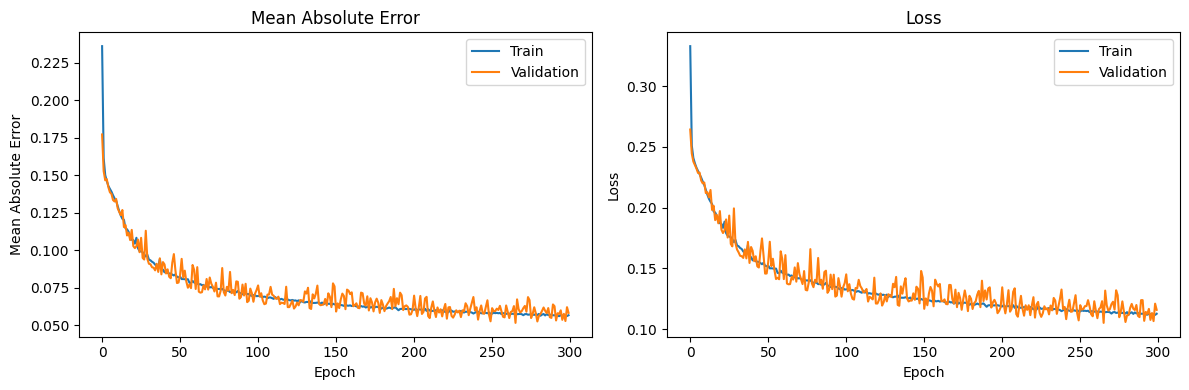

In [ ]:
def rmse_loss(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    mean_squared_error = tf.reduce_mean(squared_error)
    root_mean_squared_error = tf.sqrt(mean_squared_error)
    return root_mean_squared_error

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001,weight_decay=0.000001),
              loss=[rmse_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=5000,shuffle=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
def remove_outliers(y_pred, y_test, threshold=2):
    z_scores = np.abs((y_pred - np.mean(y_pred)) / np.std(y_pred))
    outliers_mask = z_scores > 2.0

    y_pred_filtered = y_pred[~outliers_mask]
    y_test_filtered = y_test[~outliers_mask]

    return y_pred_filtered, y_test_filtered

# Assuming you have y_pred, y_test, and X_test available
y_pred_0, y_test_filtered_0 = remove_outliers(y_pred[:, 0], y_test[:, 0], threshold=2.0)
y_pred_1, y_test_filtered_1 = remove_outliers(y_pred[:, 1], y_test[:, 1], threshold=2.0)

126/126 [==============================] - 0s 1ms/step


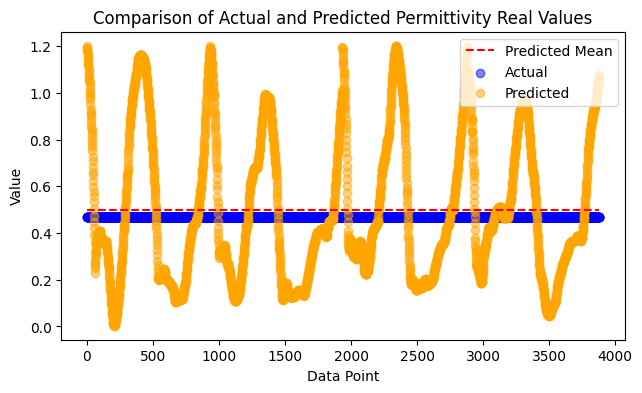

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_0) - 1], [np.mean(y_pred_0), np.mean(y_pred_0)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_0)),y_test_filtered_0, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_0)), y_pred_0, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

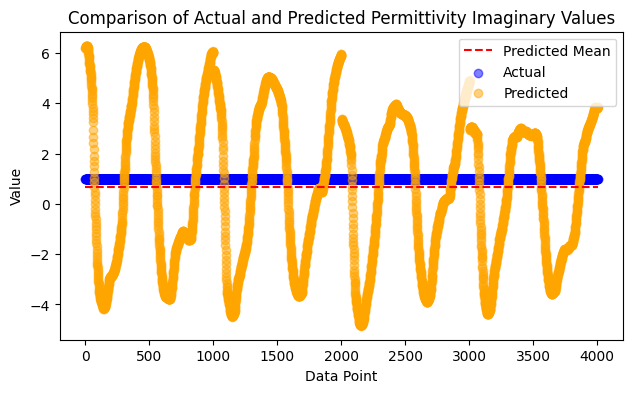

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_1) - 1], [np.mean(y_pred_1), np.mean(y_pred_1)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_1)), y_test_filtered_1, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_1)), y_pred_1, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

In [ ]:
file_paths = dict()
file_paths[0] = ["data/S_plasample_cube_40.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    dictionary = {
    0: "S11",
    1: "S21",
    2: "S12",
    3: "S22"
    }
    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = dictionary[index]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for group in range(len(all_combined_data)):
    for i in range(0, len(all_combined_data[group]), group_size):
        combined_dataframe = pd.concat(all_combined_data[group][i:i+group_size], axis=1)
        combined_dataframe.reset_index(drop=True, inplace=True)
        array.append(combined_dataframe)
testing_dataframe = pd.concat(array, axis=0)
testing_dataframe.reset_index(drop=True, inplace=True)
testing_dataframe = testing_dataframe.loc[:, ~testing_dataframe.columns.duplicated()]

In [ ]:
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [ ]:
columns = testing_dataframe.columns[1:]
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [ ]:
testing_dataframe = testing_dataframe.iloc[:,1:]

In [ ]:
columns = []
for column in training_dataframe.columns:
    if column != "Permittivity_Real" and column !="Permittivity_Imaginary":
        columns.append(column)
columns

['Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

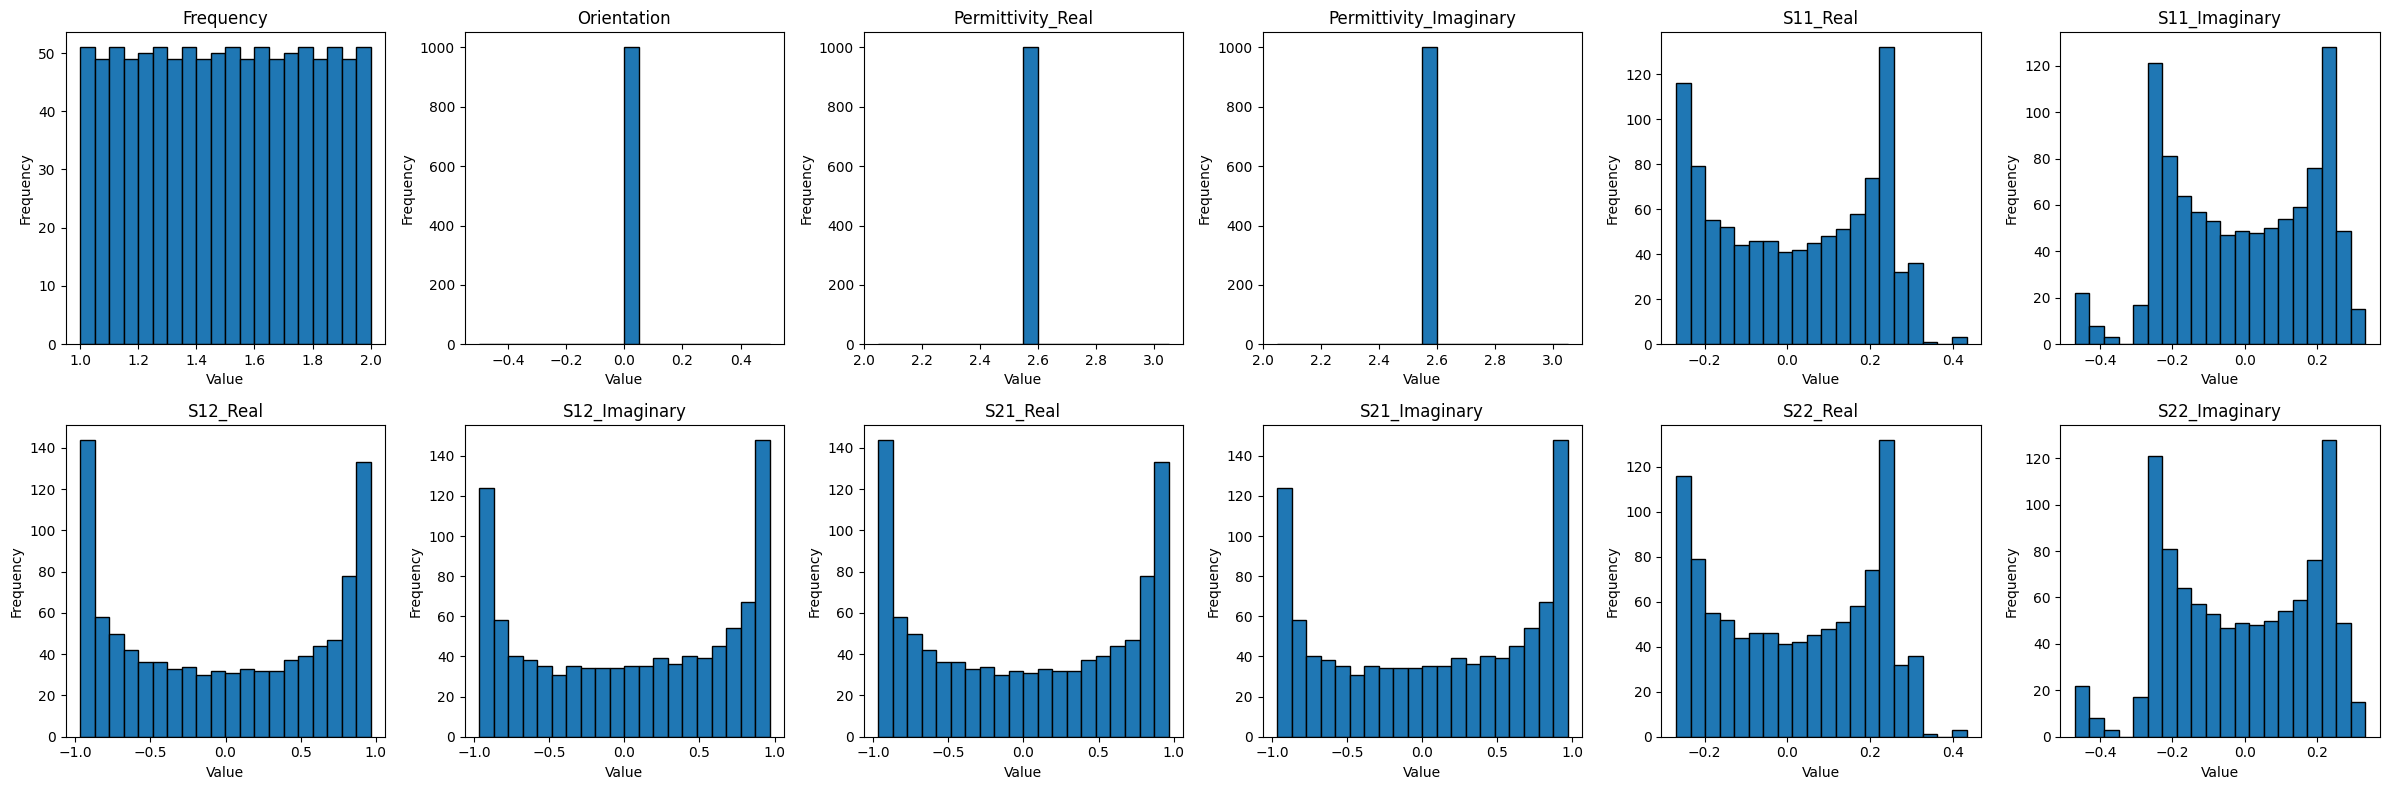

In [ ]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

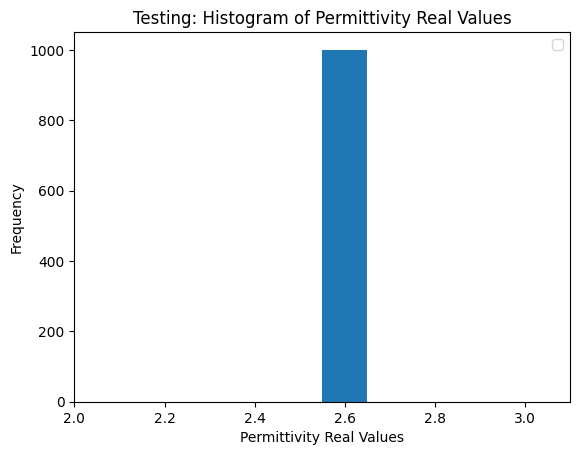

In [ ]:
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

In [ ]:
columns = testing_dataframe.columns[2:]
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

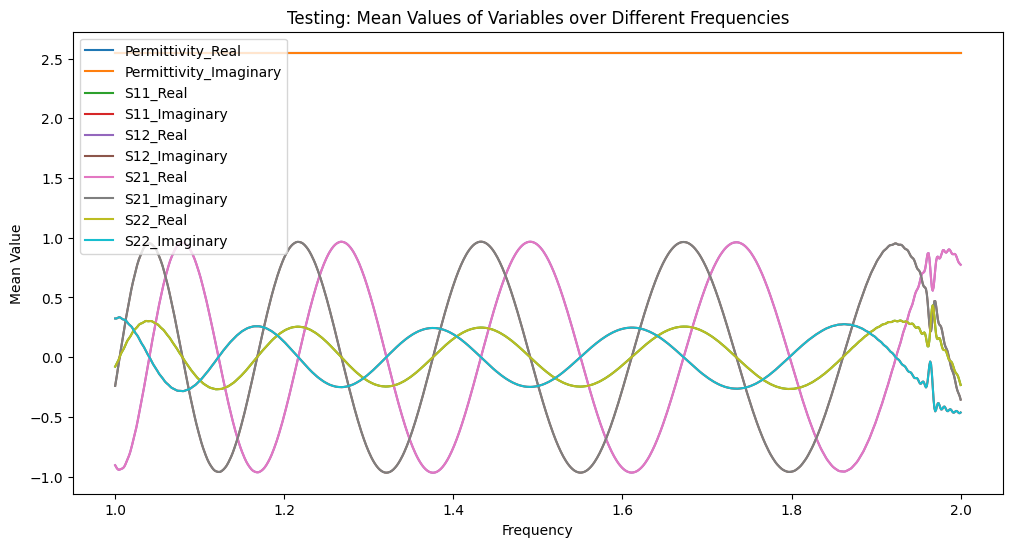

In [ ]:
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Testing: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

In [ ]:
no_id = [
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary','Permittivity_Real','Permittivity_Imaginary']

In [ ]:
testing_dataframe[testing_dataframe[no_id].columns]  = bc.transform(testing_dataframe[no_id])

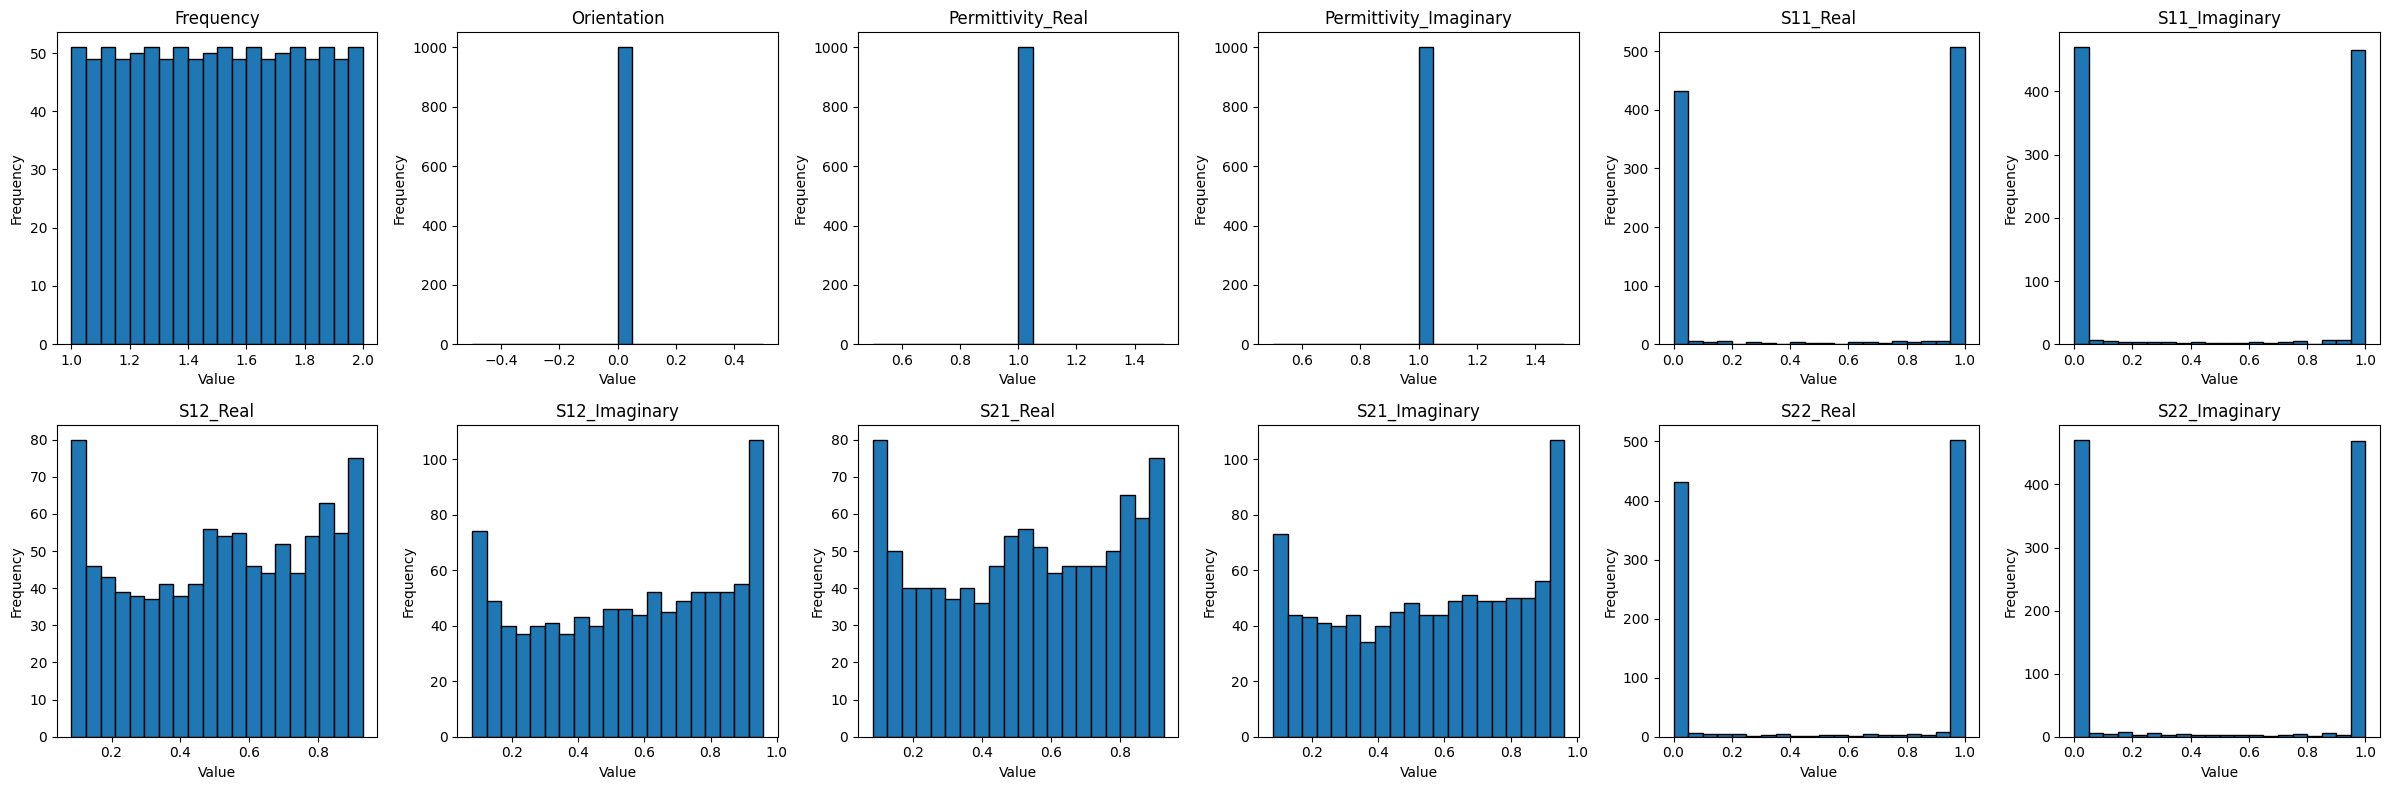

In [ ]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID"]:
        columns.append(column)
columns

['Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [ ]:
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
X_test = X_test.astype(float)
y_test = y_test.astype(float)
y_pred = model.predict(X_test)
def remove_outliers(y_pred, y_test, threshold=2):
    z_scores = np.abs((y_pred - np.mean(y_pred)) / np.std(y_pred))
    outliers_mask = z_scores > 2.0

    y_pred_filtered = y_pred[~outliers_mask]
    y_test_filtered = y_test[~outliers_mask]

    return y_pred_filtered, y_test_filtered

# Assuming you have y_pred, y_test, and X_test available
y_pred_0, y_test_filtered_0 = remove_outliers(y_pred[:, 0], y_test[:, 0], threshold=2.0)
y_pred_1, y_test_filtered_1 = remove_outliers(y_pred[:, 1], y_test[:, 1], threshold=2.0)

32/32 [==============================] - 0s 1ms/step


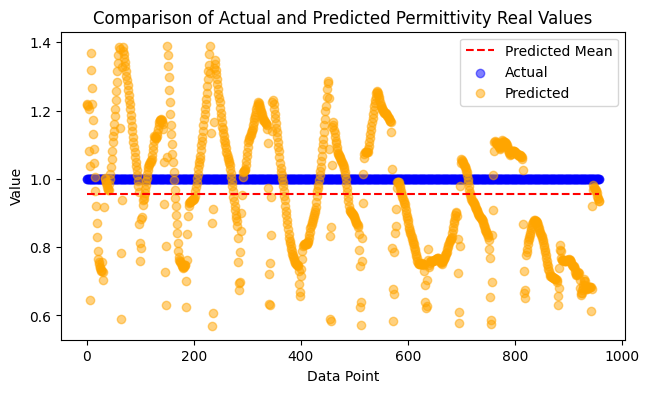

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_0) - 1], [np.mean(y_pred_0), np.mean(y_pred_0)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_0)),y_test_filtered_0, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_0)), y_pred_0, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

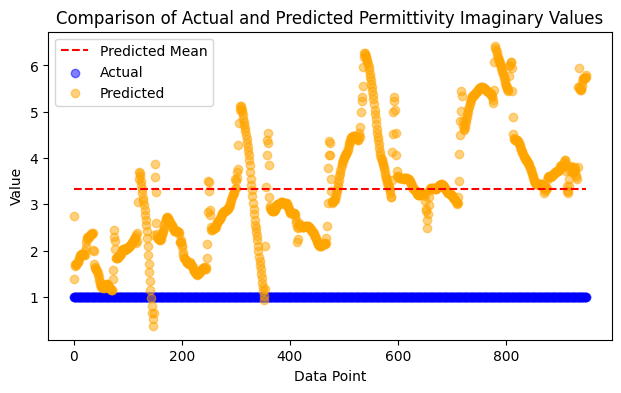

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_1) - 1], [np.mean(y_pred_1), np.mean(y_pred_1)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_1)), y_test_filtered_1, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_1)), y_pred_1, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

# CONV1D

In [ ]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID"]:
        columns.append(column)
columns

['Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [ ]:
X_train = training_dataframe[columns].values
X_train = X_train.reshape((-1, 1001, X_train.shape[1]))
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
y_train = y_train.reshape((-1, 1001, 2))
X_test = testing_dataframe[columns].values
X_test = X_test.reshape((-1, 1001, X_test.shape[1]))
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
y_test = y_test.reshape((-1, 1001, 2))
X_train = X_train.astype(float)
y_train = y_train.astype(float)[:,0,:]
X_test = X_test.astype(float)
y_test = y_test.astype(float)

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_180 (Conv1D)         (None, 999, 128)          3968      
                                                                 
 conv1d_181 (Conv1D)         (None, 997, 64)           24640     
                                                                 
 conv1d_182 (Conv1D)         (None, 995, 32)           6176      
                                                                 
 conv1d_183 (Conv1D)         (None, 993, 16)           1552      
                                                                 
 flatten_45 (Flatten)        (None, 15888)             0         
                                                                 
 dense_234 (Dense)           (None, 2)                 31778     
                                                                 
Total params: 68,114
Trainable params: 68,114
Non-tra

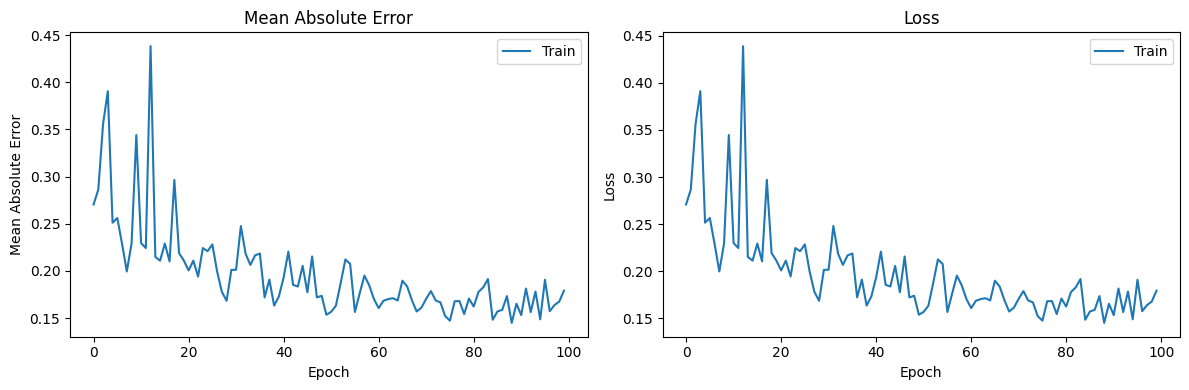

In [ ]:
def mae_loss(y_true, y_pred):
    absolute_error = tf.abs(y_true - y_pred)
    mean_absolute_error = tf.reduce_mean(absolute_error)
    return mean_absolute_error

model = keras.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(1001,X_train.shape[2]),kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.000001)),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.000001)),
        keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.000001)),
        keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.000001)),
        keras.layers.Flatten(),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])



model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001,weight_decay=0.000001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=20,shuffle=False)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'])
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
def remove_outliers(y_pred, y_test, threshold=2):
    z_scores = np.abs((y_pred - np.mean(y_pred)) / np.std(y_pred))
    outliers_mask = z_scores > 2.0

    y_pred_filtered = y_pred[~outliers_mask]
    y_test_filtered = y_test[~outliers_mask]

    return y_pred_filtered, y_test_filtered

# Assuming you have y_pred, y_test, and X_test available
y_pred_0, y_test_filtered_0 = remove_outliers(y_pred[:, 0], y_test[:,0, 0], threshold=2.0)
y_pred_1, y_test_filtered_1 = remove_outliers(y_pred[:, 1], y_test[:,0, 1], threshold=2.0)

1/1 [==============================] - 0s 84ms/step


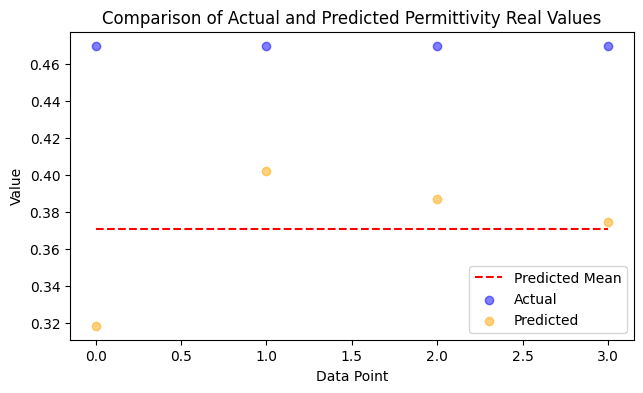

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_0) - 1], [np.mean(y_pred_0), np.mean(y_pred_0)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_0)),y_test_filtered_0, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_0)), y_pred_0, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

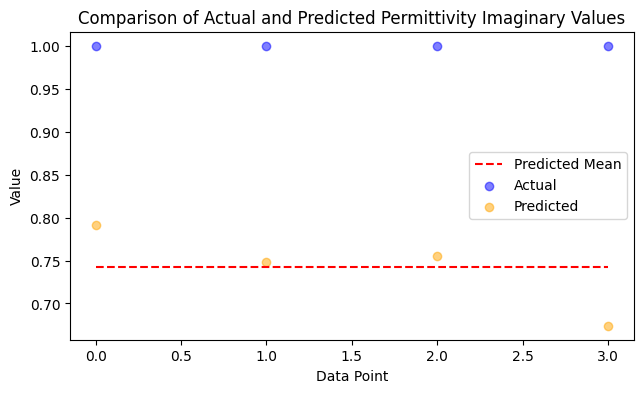

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_1) - 1], [np.mean(y_pred_1), np.mean(y_pred_1)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_1)), y_test_filtered_1, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_1)), y_pred_1, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

# LSTM

In [996]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID"]:
        columns.append(column)
columns

['Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [997]:
X_train = training_dataframe[columns].values
X_train = X_train.reshape((-1, 1001, X_train.shape[1]))
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
y_train = y_train.reshape((-1, 1001, 2))
X_test = testing_dataframe[columns].values
X_test = X_test.reshape((-1, 1001, X_test.shape[1]))
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
y_test = y_test.reshape((-1, 1001, 2))
X_train = X_train.astype(float)
y_train = y_train.astype(float)[:,0,:]
X_test = X_test.astype(float)
y_test = y_test.astype(float)

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 1001, 128)         71168     
                                                                 
 global_average_pooling1d_25  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_256 (Dense)           (None, 2)                 258       
                                                                 
Total params: 71,426
Trainable params: 71,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
20/20 [==============================] - 3s 51ms/step - loss: 0.6087 - mean_absolute_error: 0.6077 - mean_squared_error: 0.5588
Epoch 2/75
20/20 [==============================] - 2s 92ms/step - loss: 0.4045 - mean_absolute_error: 0.40

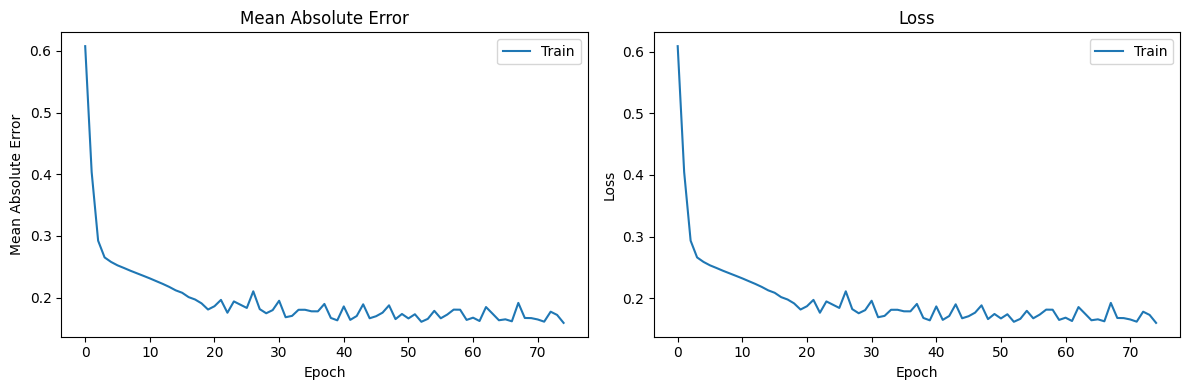

In [1002]:
def mae_loss(y_true, y_pred):
    absolute_error = tf.abs(y_true - y_pred)
    mean_absolute_error = tf.reduce_mean(absolute_error)
    return mean_absolute_error

model = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=(1001,X_train.shape[2]),kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(0.000001)),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])



model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001,weight_decay=0.0000001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
model.summary()
history = model.fit(X_train, y_train, epochs=75, batch_size=20,shuffle=False)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'])
plt.tight_layout()
plt.show()

In [1003]:
y_pred = model.predict(X_test)
def remove_outliers(y_pred, y_test, threshold=2):
    z_scores = np.abs((y_pred - np.mean(y_pred)) / np.std(y_pred))
    outliers_mask = z_scores > 2.0

    y_pred_filtered = y_pred[~outliers_mask]
    y_test_filtered = y_test[~outliers_mask]

    return y_pred_filtered, y_test_filtered

# Assuming you have y_pred, y_test, and X_test available
y_pred_0, y_test_filtered_0 = remove_outliers(y_pred[:, 0], y_test[:,0, 0], threshold=2.0)
y_pred_1, y_test_filtered_1 = remove_outliers(y_pred[:, 1], y_test[:,0, 1], threshold=2.0)

1/1 [==============================] - 1s 897ms/step


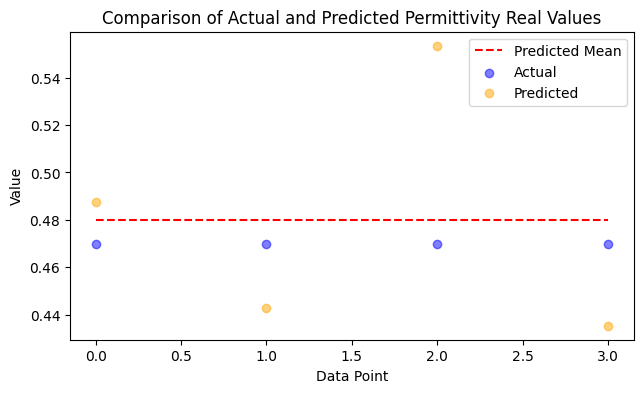

In [1004]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_0) - 1], [np.mean(y_pred_0), np.mean(y_pred_0)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_0)),y_test_filtered_0, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_0)), y_pred_0, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

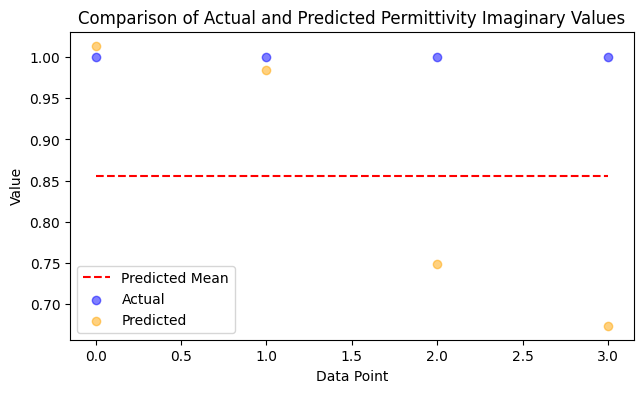

In [1005]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(y_test_filtered_1) - 1], [np.mean(y_pred_1), np.mean(y_pred_1)], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(y_test_filtered_1)), y_test_filtered_1, label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(y_test_filtered_1)), y_pred_1, label='Predicted', color='orange', alpha=0.5)
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()